In [ ]:
%%capture
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Langer Seminar/data/sentiment"
dataset_path = '/content/drive/MyDrive/Langer Seminar/data/sentiment/classification'

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import json
from datasets import load_dataset, load_metric
import torch
from dataclasses import dataclass
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from torch.optim import AdamW
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

In [ ]:
dataset = load_dataset("json", data_files={"train": dataset_path + "/classification_sentiment_train.jsonl",
                                          "test": dataset_path + "/classification_sentiment_eval.jsonl"})

print(dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-4e8d201224b56055/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 10000
    })
})


In [ ]:
train_val_split = dataset["train"].train_test_split(0.25)

In [ ]:
dataset["train"] = train_val_split["train"]
dataset["validation"] = train_val_split["test"]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 10000
    })
})


In [ ]:
num_labels = 2
pretrained_model = "roberta-base"

# Hyperparameters

num_train_epochs = 2
learning_rate = 5e-5
batch_size = 16

In [ ]:
id2label = {0:"negative", 1:"positive"}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model, use_fast=True)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
max_len = 512
pad_to_max = False
def tokenize_function(example):
    text = example['text']
    encodings = tokenizer.encode_plus(text, pad_to_max_length=pad_to_max, 
                                      max_length=max_len,
                                      add_special_tokens=True,
                                      return_attention_mask=True,
                                      )
    sentiment = example['sentiment']
    encodings.update({'sentiment': label2id[sentiment]}) 
    
    return encodings



tokenized_dataset = dataset.map(tokenize_function)

  0%|          | 0/30000 [00:00<?, ?ex/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

In [ ]:
tokenized_dataset = tokenized_dataset.rename_column("sentiment", "labels")
tokenized_dataset = tokenized_dataset.remove_columns("text")
tokenized_dataset.column_names

{'train': ['labels', 'input_ids', 'attention_mask'],
 'test': ['labels', 'input_ids', 'attention_mask'],
 'validation': ['labels', 'input_ids', 'attention_mask']}

In [ ]:
print("Input IDs:", tokenized_dataset["train"]["input_ids"][0])
print("Attention mask:", tokenized_dataset["train"]["attention_mask"][0])
print("Labels:", tokenized_dataset["train"]["labels"][0])

Input IDs: [0, 100, 10728, 218, 75, 216, 147, 7, 1642, 77, 9311, 10, 1569, 25, 31790, 25, 16879, 32091, 7, 1327, 4, 14747, 31, 80, 50, 130, 205, 17216, 32807, 1328, 5, 822, 6, 89, 16, 1085, 1313, 59, 42, 1946, 12, 463, 12, 102, 12, 4809, 3844, 9, 86, 8, 301, 4, 85, 16, 3997, 14, 951, 21, 441, 7, 1062, 62, 10, 333, 9, 82, 2882, 7, 1760, 6, 822, 6, 8, 17668, 42, 2125, 9, 8875, 6, 8, 190, 55, 3997, 14, 42, 16, 5, 4413, 18513, 11, 5, 16879, 651, 4, 50118, 50118, 14229, 5, 1273, 7751, 9, 5, 1569, 6, 52, 192, 16879, 12681, 220, 7, 1337, 1704, 8720, 6, 215, 25, 11678, 17683, 8, 5, 3885, 9, 1704, 3122, 6, 442, 2419, 8, 18693, 14, 74, 1153, 146, 144, 155, 2586, 12003, 268, 7923, 4, 152, 1273, 1310, 2029, 5, 18754, 10, 5840, 9, 16879, 18, 7690, 3881, 23, 12073, 6, 8, 13905, 141, 39, 5313, 5712, 3269, 6164, 207, 9, 5, 86, 4, 50118, 50118, 133, 78, 631, 14, 269, 478, 162, 59, 42, 1569, 16, 141, 1099, 5, 3501, 16, 4, 7632, 11, 5, 822, 16, 10, 6097, 230, 12, 38428, 2701, 6, 53, 9369, 22242, 3311, 66

In [ ]:
def pad_seq(seq, max_batch_len, pad_value):
    return seq + (max_batch_len - len(seq)) * [pad_value]


@dataclass
class SmartCollator():
    pad_token_id: int

    def __call__(self, batch):
        batch_inputs = list()
        batch_attention_masks = list()
        labels = list()
        max_size = max([len(ex['input_ids']) for ex in batch])
        for item in batch:
            batch_inputs += [pad_seq(item['input_ids'], max_size, self.pad_token_id)]
            batch_attention_masks += [pad_seq(item['attention_mask'], max_size, 0)]
            labels.append(item['labels'])

        return {"input_ids": torch.tensor(batch_inputs, dtype=torch.long),
                "attention_mask": torch.tensor(batch_attention_masks, dtype=torch.long),
                "labels": torch.tensor(labels, dtype=torch.long)
                }


data_collator = SmartCollator(pad_token_id=tokenizer.pad_token_id)

In [ ]:
train_dataloader = DataLoader(
  tokenized_dataset["train"] , shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
  tokenized_dataset["validation"], batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
  tokenized_dataset["test"], batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(pretrained_model, 
                                                          num_labels=num_labels,
                                                          id2label=id2label,
                                                          label2id=label2id)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_train_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


In [ ]:
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

<ipython-input-20-aea68bdc5332>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [ ]:
# training loop with evaluation every 300 steps

progress_bar = tqdm(range(num_training_steps))

wandb.init(project="classification_seminar_sentiment")

model.train()

for epoch in range(num_train_epochs):

    wandb.log({"epoch": epoch + 1})

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_train_epochs))
    print('Training...')

    train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        if step % 600 == 0 and not step == 0:

            print("")
            print("Running Validation...")

            wandb.log({"train_loss": train_loss / step})

            eval_progress_bar = tqdm(range(len(eval_dataloader)))

            eval_loss = 0

            model.eval()
            eval_loss = 0
            for batch in eval_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                with torch.no_grad():
                    outputs = model(**batch)

                logits = outputs.logits
                loss = outputs.loss
                eval_loss += loss.item()
                predictions = torch.argmax(logits, dim=-1)
                accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
                f1_metric.add_batch(predictions=predictions, references=batch["labels"])

                eval_progress_bar.update(1)


            eval_accuracy = accuracy_metric.compute()
            eval_f1 = f1_metric.compute(average="macro")

            wandb.log({"eval_loss": eval_loss/len(eval_dataloader)})
            wandb.log({"eval_accuracy":eval_accuracy["accuracy"]})
            wandb.log({"eval_f1":eval_f1["f1"]})


        progress_bar.update(1)

  0%|          | 0/3750 [00:00<?, ?it/s]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



======== Epoch 1 / 2 ========
Training...

Running Validation...


  0%|          | 0/625 [00:00<?, ?it/s]


Running Validation...


  0%|          | 0/625 [00:00<?, ?it/s]


Running Validation...


  0%|          | 0/625 [00:00<?, ?it/s]


======== Epoch 2 / 2 ========
Training...

Running Validation...


  0%|          | 0/625 [00:00<?, ?it/s]


Running Validation...


  0%|          | 0/625 [00:00<?, ?it/s]


Running Validation...


  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
# final evaluation on the test set

y_pred = []

model.eval()

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    f1_metric.add_batch(predictions=predictions, references=batch["labels"])

    y_pred.append(predictions)


print(accuracy_metric.compute())
print(f1_metric.compute(average="macro"))

{'accuracy': 0.954}
{'f1': 0.9539997350384738}


In [ ]:
model.save_pretrained(base_path + f"/model_{num_train_epochs}_{batch_size}_{learning_rate}_{max_len}")

In [ ]:
start, end = y_pred[:-1], y_pred[-1]
start = torch.flatten(torch.stack(start))

predictions = torch.concat((start, end))

gold = tokenized_dataset["test"]["labels"]

target_names = ["negative", "positive"]


report = classification_report(gold, predictions.cpu(), labels=[0,1], target_names=target_names, digits=3)
print(report)


with open(base_path + f"/classification_report_{num_train_epochs}_{batch_size}_{learning_rate}_{max_len}.txt", "w", encoding="utf8") as outfile:
  outfile.write("#Info:\n")
  outfile.write("Classifier: {0}\n".format(pretrained_model))
  outfile.write("Labels: {0}\n".format(target_names))
  outfile.write("\n#Counts:\n")
  outfile.write("Number of training data_records: {0}\n".format(len(dataset["train"])))
  outfile.write("Number of classified data_records: {0}\n".format(len(dataset["test"])))
  outfile.write("\n#Hyperparameters:\n")
  outfile.write(f"Epochs: {num_train_epochs}\nBatch size: {batch_size}\nLearning rate: {learning_rate}\n")
  outfile.write("\n#Classification report:\n{0}\n".format(report))

              precision    recall  f1-score   support

    negative      0.953     0.954     0.954      4985
    positive      0.955     0.954     0.954      5015

    accuracy                          0.954     10000
   macro avg      0.954     0.954     0.954     10000
weighted avg      0.954     0.954     0.954     10000



In [ ]:
cm = confusion_matrix(gold, predictions.cpu())
print(cm)

[[4758  227]
 [ 233 4782]]


In [ ]:
def plot_and_store_confusion_matrix(y_true: list,
                                    y_pred:list,
                                    file_name: str,
                                    normalize=True,
                                    cmap=plt.cm.Blues,
                                    show=False):
    """
    This function prints and plots the confusion matrix, and saves it to a file
    :param y_true: The true classes
    :param y_pred: The predicted classes
    :param file_name: The file name to store the image of the confusion matrix
    :param normalize: normalize numbers (counts to relative counts)
    :param cmap: Layout
    :param show: Display the matrix. If false, only store it
    :return: Nothing
    """
    np.set_printoptions(precision=3)
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=[10,8])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=["negative", "positive"], yticklabels=["negative", "positive"],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(file_name)
    if show:
        plt.show()

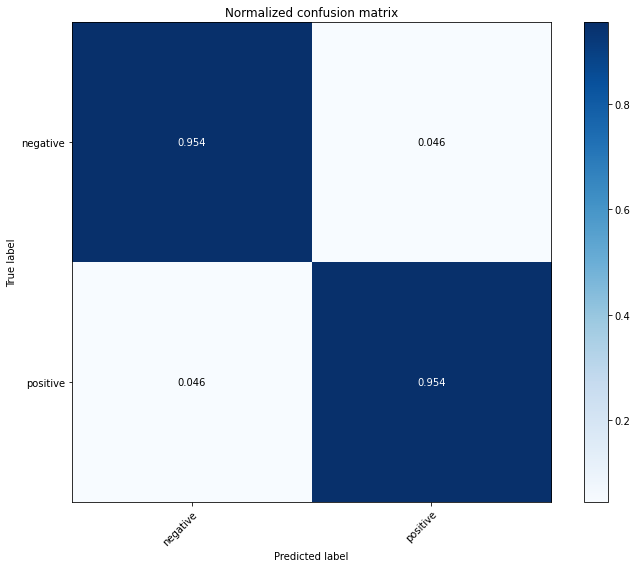

In [ ]:
plot_and_store_confusion_matrix(gold, predictions.cpu(), base_path + f"/confusion_matrix_{num_train_epochs}_{batch_size}_{learning_rate}_{max_len}")